# FSRS4Anki v6.1.2 Optimizer

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/v6.1.2/fsrs4anki_optimizer.ipynb)

↑ Click the above button to open the optimizer on Google Colab.

> If you can't see the button and are located in the Chinese Mainland, please use a proxy or VPN.

Upload your **Anki Deck Package (.apkg)** file or **Anki Collection Package (.colpkg)** file on the `Left sidebar -> Files`, drag and drop your file in the current directory (not the `sample_data` directory).

No need to include media. Need to include scheduling information.

> If you use the latest version of Anki, please check the box `Support older Anki versions (slower/larger files)` when you export.

You can export it via `File -> Export...` or `Ctrl + E` in the main window of Anki.

Then replace the `filename` with yours in the next code cell. And set the `timezone` and `next_day_starts_at` which can be found in your preferences of Anki.

After that, just run all (`Runtime -> Run all` or `Ctrl + F9`) and wait for minutes. You can see the optimal parameters in section **2.3 Result**. Copy them, replace the parameters in `fsrs4anki_scheduler.js`, and paste them into the custom scheduling of your deck options (require Anki version >= 2.1.55).

**NOTE**: The default output is generated from my review logs. If you find the output is the same as mine, maybe your notebook hasn't run there.

**Contribute to SRS Research**: If you want to share your data with me, please fill this form: https://forms.gle/KaojsBbhMCytaA7h8

In [1]:
# Here are some settings that you need to replace before running this optimizer.

filename = "All Decks.apkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpkg filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'America/Caracas'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"  # YYYY-MM-DD

# Set it to True if you don't want the optimizer to use the review logs from suspended cards.
filter_out_suspended_cards = False

# Red: 1, Orange: 2, Green: 3, Blue: 4, Pink: 5, Turquoise: 6, Purple: 7
# Set it to [1, 2] if you don't want the optimizer to use the review logs from cards with red or orange flag.
filter_out_flags = []

enable_short_term = True

recency_weight = True

## 1 Build dataset

### 1.1 Extract Anki collection & deck file

In [2]:
%pip install -q fsrs_optimizer==6.1.4
# for local development
# import os
# import sys
# sys.path.insert(0, os.path.abspath('../fsrs-optimizer/src/fsrs_optimizer/'))
import fsrs_optimizer as optimizer
optimizer = optimizer.Optimizer(enable_short_term=enable_short_term)
optimizer.anki_extract(filename, filter_out_suspended_cards, filter_out_flags)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### 1.2 Create time-series feature & analysis

The following code cell will extract the review logs from your Anki collection and preprocess them to a trainset which is saved in [./revlog_history.tsv](./revlog_history.tsv).

The time-series features are important in optimizing the model's parameters. For more detail, please see my paper: https://www.maimemo.com/paper/

Then it will generate a concise analysis for your review logs.

- The `r_history` is the history of ratings on each review. `3,3,3,1` means that you press `Good, Good, Good, Again`. It only contains the first rating for each card on the review date, i.e., when you press `Again` in review and  `Good` in relearning steps 10min later, only `Again` will be recorded.
- The `avg_interval` is the actual average interval after you rate your cards as the `r_history`. It could be longer than the interval given by Anki's built-in scheduler because you reviewed some overdue cards.
- The `avg_retention` is the average retention after you press as the `r_history`. `Again` counts as failed recall, and `Hard, Good and Easy` count as successful recall. Retention is the percentage of your successful recall.
- The `stability` is the estimated memory state variable, which is an approximate interval that leads to 90% retention.
- The `factor` is `stability / previous stability`.
- The `group_cnt` is the number of review logs that have the same `r_history`.

In [3]:
analysis = optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at)
print(analysis)

  0%|          | 0/9024 [00:00<?, ?it/s]

Trainset saved.
Retention calculated.


  0%|          | 0/465 [00:00<?, ?it/s]

Stability calculated.


analysis:   0%|          | 0/43 [00:00<?, ?it/s]

Analysis saved!
1:again, 2:hard, 3:good, 4:easy
first_rating  i r_history  avg_interval  avg_retention  stability  factor  group_cnt
           1  2   (1,3,3)           1.0          0.970        6.1     inf        121
           2  2   (2,3,3)           2.2          0.971       12.0     inf        126
           3  2     (3,3)           1.7          0.987       33.8     inf        422
           3  3   (3,3),3           4.4          0.971       17.6    0.52        106
           4  2       (4)           4.9          0.990       69.9     inf       2674
           4  3     (4),3          15.2          0.979       96.3    1.38        279


## 2 Optimize parameter

### 2.1 Define & Train the model

FSRS is a time-series model for predicting memory states.

The [./revlog_history.tsv](./revlog_history.tsv) generated before will be used for training the FSRS model.

In [5]:
optimizer.define_model()
optimizer.pretrain(verbose=False)
optimizer.train(verbose=False, recency_weight=recency_weight)

  0%|          | 0/6779 [00:00<?, ?it/s]

[]

### 2.2 Result

Copy the optimal parameters for FSRS for you in the output of next code cell after running.

In [6]:
print(optimizer.w)

[4.1673, 8.4165, 28.0686, 99.9991, 6.3867, 0.7231, 3.052, 0.0871, 1.9619, 0.0464, 0.8748, 1.5643, 0.0312, 0.4254, 1.6786, 0.4484, 2.2478, 0.5215, 0.3201, 0.0106, 0.2372]


<font color=orange>Note: These values should be used with build-in FSRS of Anki 23.12 or custom scheduling script of FSRS4Anki v4.11.0</font>

### 2.3 Preview

You can see the memory states and intervals generated by FSRS as if you press the good in each review at the due date scheduled by FSRS.

In [7]:
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9

preview = optimizer.preview(requestRetention)
print(preview)

1:again, 2:hard, 3:good, 4:easy

first rating: 1
rating history: (1,3,3),3,3,3,3,3,3,3,3
interval history: 0.0d,0.0d,0.0d,6.0d,27.0d,4.1m,1.6y,7.2y,33.0y,100.0y,100.0y
factor history: 0.0,0.0,0.0,0.0,4.50,4.59,4.63,4.61,4.55,3.03,1.00
difficulty history: 0,6.4,5.7,5.1,4.5,4.0,3.5,3.1,2.7,2.4,2.0
stability history: 0,4.2,4.9,5.6,26.6,123.9,573.9,2644.7,12045.0,36500.0,36500.0

first rating: 2
rating history: (2,3,3),3,3,3,3,3,3,3,3
interval history: 0.0d,0.0d,0.0d,11.0d,1.8m,9.0m,3.6y,17.3y,80.9y,100.0y,100.0y
factor history: 0.0,0.0,0.0,0.0,5.00,4.93,4.87,4.78,4.68,1.24,1.00
difficulty history: 0,5.3,4.7,4.2,3.7,3.3,2.9,2.5,2.2,1.9,1.6
stability history: 0,8.4,9.7,11.2,54.8,270.7,1319.3,6311.3,29532.9,36500.0,36500.0

first rating: 3
rating history: (3,3),3,3,3,3,3,3,3,3,3
interval history: 0.0d,0.0d,1.1m,5.9m,2.6y,13.8y,69.5y,100.0y,100.0y,100.0y,100.0y
factor history: 0.0,0.0,0.0,5.56,5.40,5.23,5.04,1.44,1.00,1.00,1.00
difficulty history: 0,3.1,2.7,2.4,2.1,1.8,1.5,1.2,1.0,1.0,1.0
sta

You can change the `test_rating_sequence` to see the scheduling intervals in different ratings.

In [8]:
test_rating_sequence = "3,3,3,3,3,1,1,3,3,3,3,3"
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9

preview_sequence = optimizer.preview_sequence(
    test_rating_sequence, requestRetention)
print(preview_sequence)

rating history: 3,3,3,3,3,1,1,3,3,3,3,3
interval history: 0.0d,28.0d,5.0m,2.2y,11.1y,55.0y,4.0m,12.0d,1.1m,3.3m,11.3m,3.3y,12.5y
factor history: 0.0,0.0,5.39,5.25,5.11,4.95,0.01,0.10,2.67,3.12,3.39,3.60,3.74
difficulty history: 0,3.1,2.7,2.4,2.1,1.8,6.6,8.0,7.2,6.4,5.8,5.1,4.6


### 2.4 Predict memory states and distribution of difficulty

Predict memory states for each review group and save them in [./prediction.tsv](./prediction.tsv).

Meanwhile, it will count the distribution of difficulty.

In [9]:
optimizer.predict_memory_states()

,count
difficulty,
1,0.574716
2,0.021685
3,0.079510
4,0.069627
5,0.083493
6,0.113144
7,0.057236
8,0.000590


## 3 Optimize retention to minimize the time of reviews (deprecated)

Calculate the optimal retention to minimize the time for long-term memory consolidation. It is an experimental feature. You can use the built-in simulator to get more accurate results.

This feature is not recommended in v6.0.0. If you still want to use it, please uncomment the following code cell.

In [ ]:
# figs = optimizer.find_optimal_retention(
#     learn_span=365,  # days to learn
#     max_ivl=36500,  # days
# )

## 4 Evaluate the model

### 4.1 Loss

Evaluate the model with the log loss. It will compare the log loss between initial model and trained model.

And it will predict the stability, difficulty and retrievability for each revlog in [./evaluation.tsv](./evaluation.tsv).

In [10]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")

Loss before training: 0.1487
Loss after training: 0.0919


### 4.2 Calibration graph

1. FSRS predicts the stability and retention for each review.
2. Reviews are grouped into 40 bins according to their predicted retention.
3. Count the true retention of each bin.
4. Plot (predicted retention, true retention) in the line graph.
5. Plot (predicted retention, size of bin) in the bar graph.
6. Combine these graphs to create the calibration graph.

Ideally, the blue line should be aligned with the orange one. If the blue line is higher than the orange line, the FSRS underestimates the retention. When the size of reviews within a bin is small, actual retention may deviate largely, which is normal.

R-squared (aka the coefficient of determination), is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). The higher the R-squared, the better the model fits your data. For details, please see https://en.wikipedia.org/wiki/Coefficient_of_determination

RMSE (root mean squared error) is the square root of the average of squared differences between prediction and actual observation. The lower the RMSE, the better the model fits your data. For details, please see https://en.wikipedia.org/wiki/Root-mean-square_deviation

Last rating = all
R-squared: 0.4732
MAE: 0.0060
ICI: 0.0050
E50: 0.0050
E90: 0.0124
EMax: 0.0896
RMSE(bins): 0.0139
AUC: 0.7079
LogLoss: 0.0837

Last rating = 1
R-squared: 0.3616
MAE: 0.0335
ICI: 0.0191
E50: 0.0165
E90: 0.0380
EMax: 0.0845
RMSE(bins): 0.0357
AUC: 0.7431
LogLoss: 0.1474

Last rating = 2
R-squared: -4.6001
MAE: 0.0254
ICI: 0.0233
E50: 0.0261
E90: 0.0391
EMax: 0.0664
RMSE(bins): 0.0245
AUC: 0.5082
LogLoss: 0.2009

Last rating = 3
R-squared: 0.1544
MAE: 0.0087
ICI: 0.0068
E50: 0.0048
E90: 0.0164
EMax: 0.5780
RMSE(bins): 0.0123
AUC: 0.6558
LogLoss: 0.0840

Last rating = 4
R-squared: -8.7073
MAE: 0.0049
ICI: 0.0049
E50: 0.0041
E90: 0.0112
EMax: 0.0647
RMSE(bins): 0.0099
AUC: 0.6199
LogLoss: 0.0241



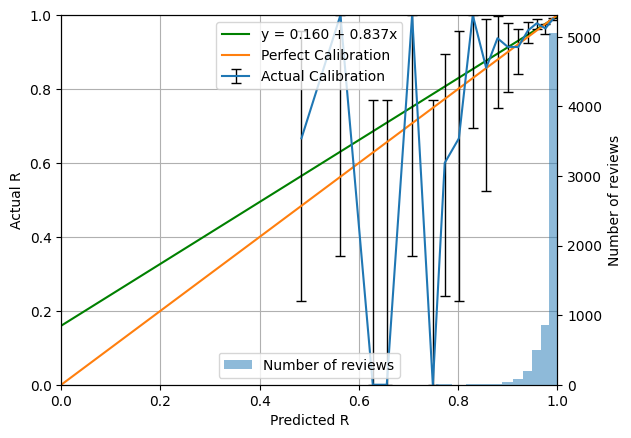

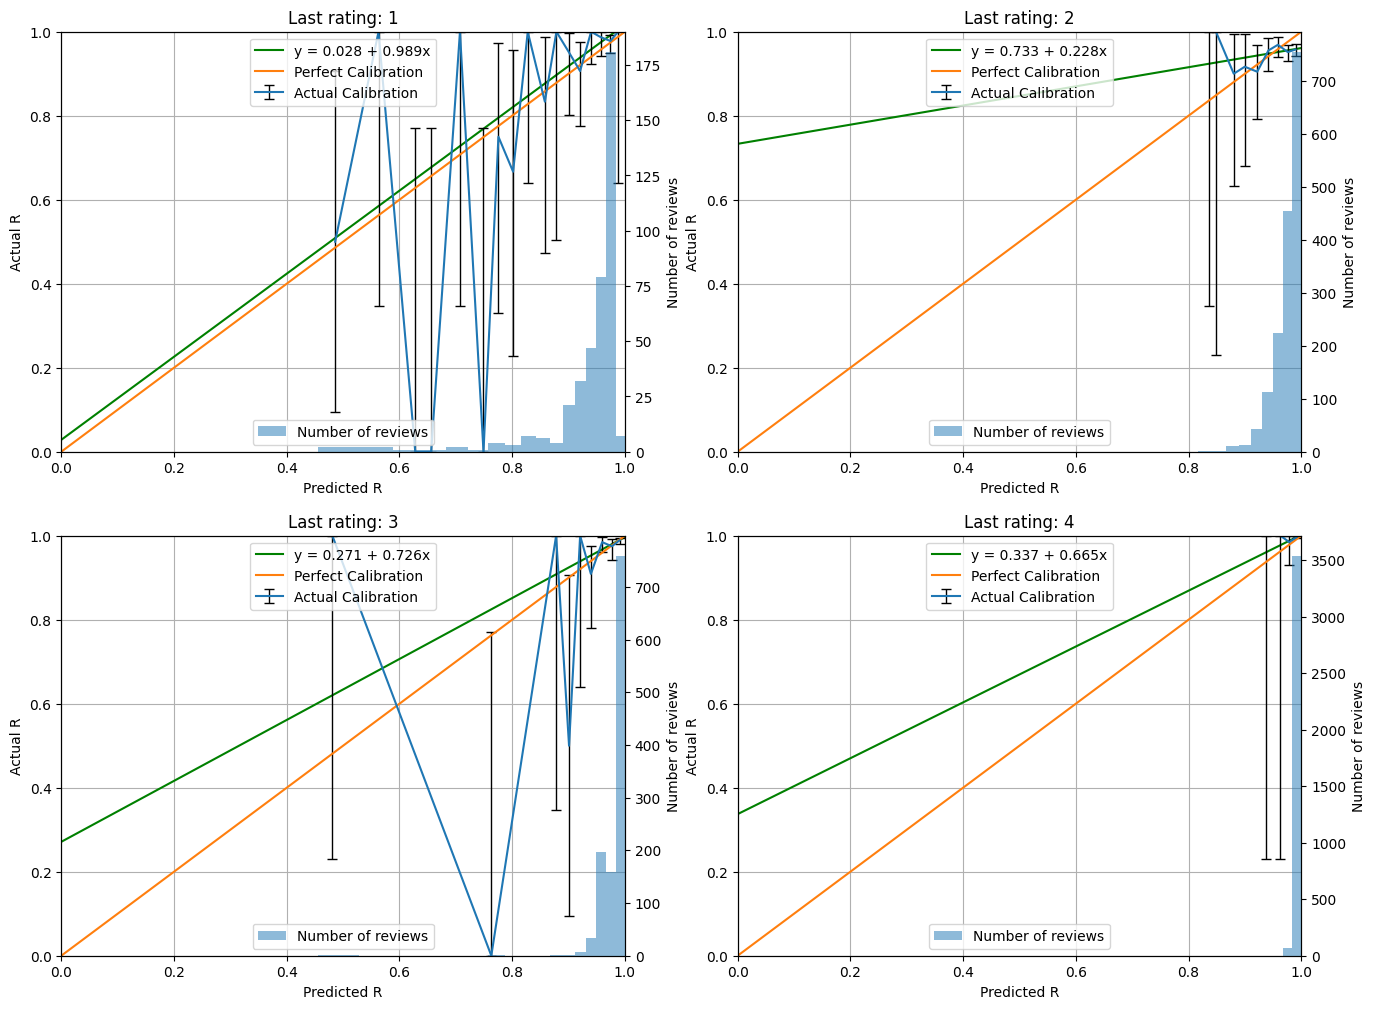

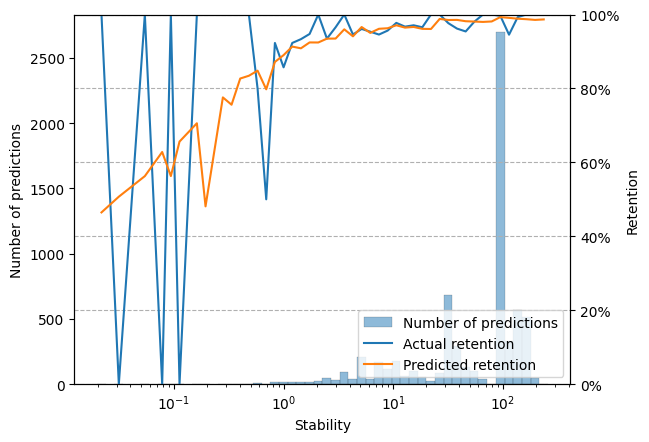

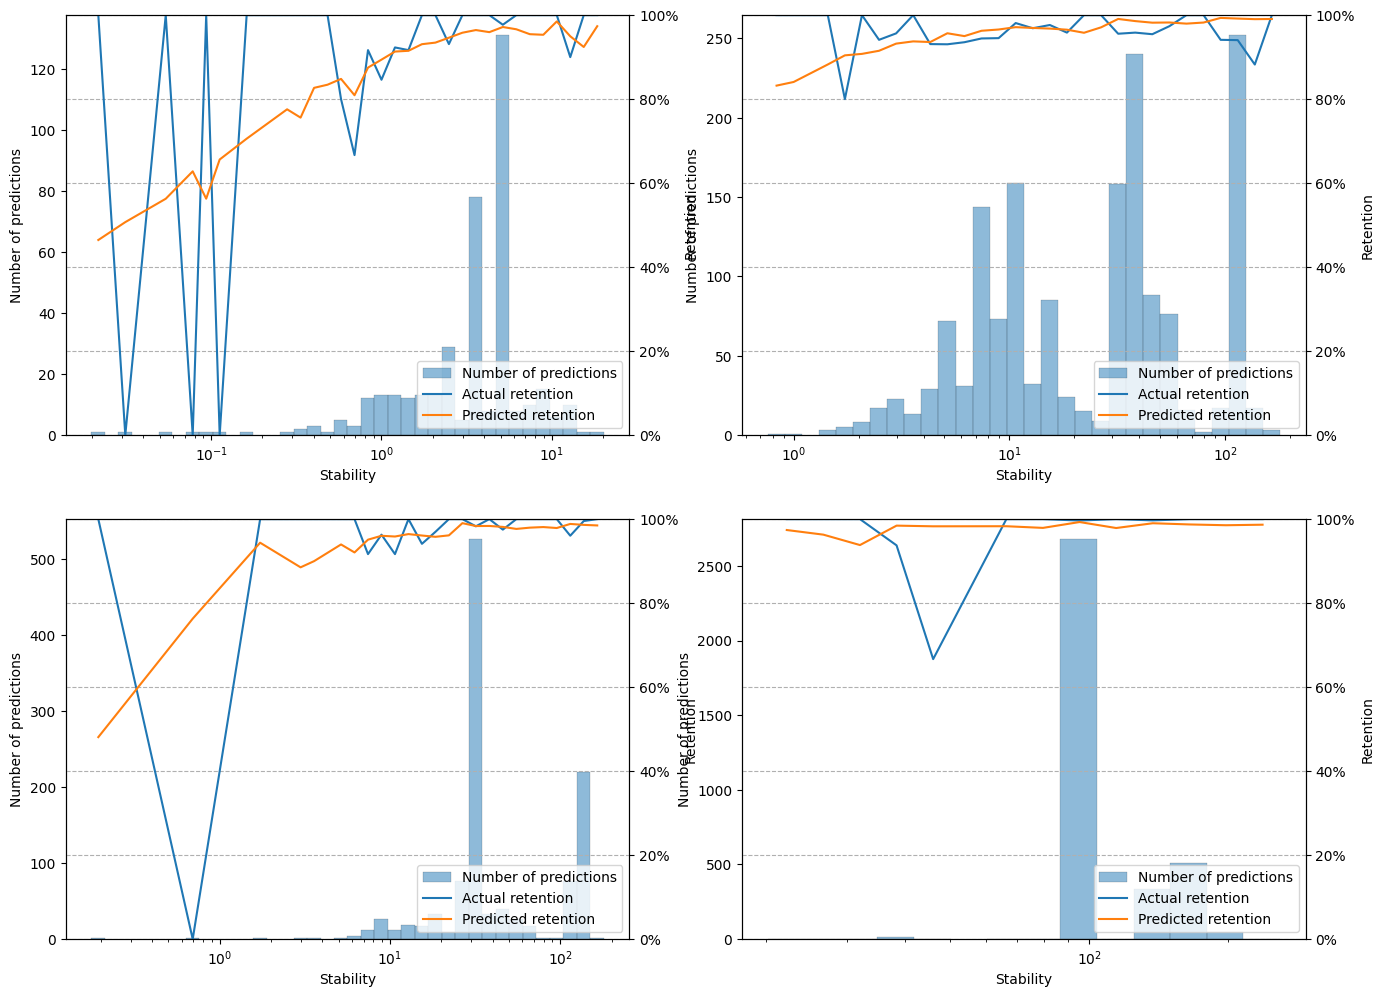

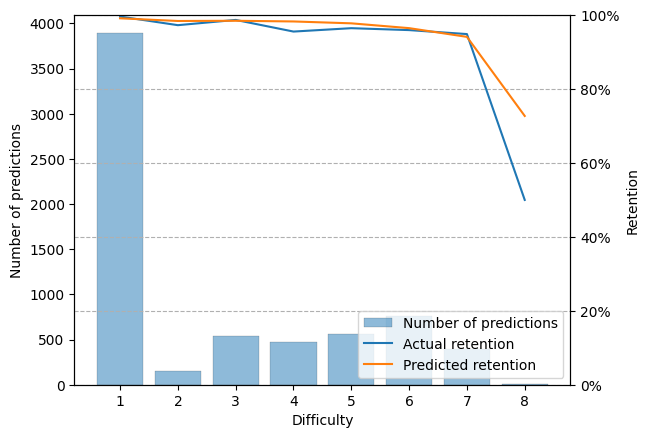

In [11]:
metrics, figs = optimizer.calibration_graph(verbose=False)

for partition in metrics:
    print(f"Last rating = {partition}")
    for metric in metrics[partition]:
        print(f"{metric}: {metrics[partition][metric]:.4f}")
    print()

for f in figs:
    f.show()

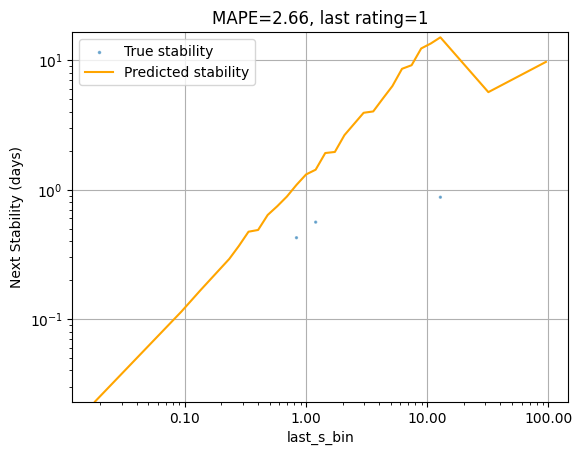

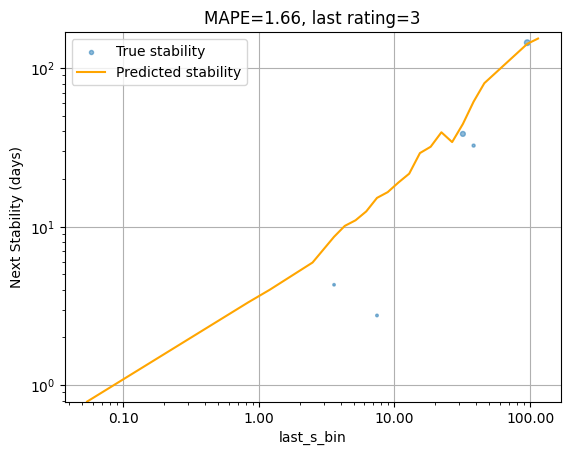

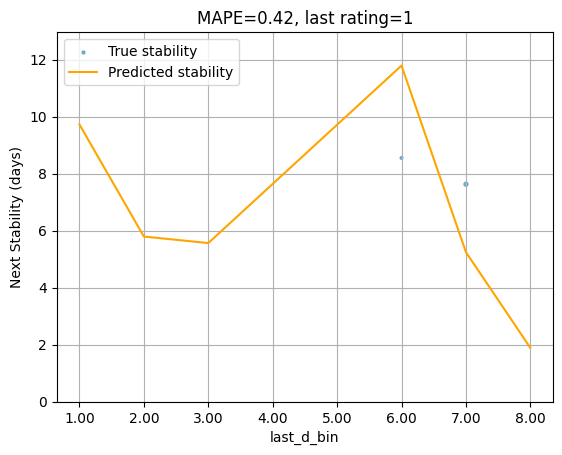

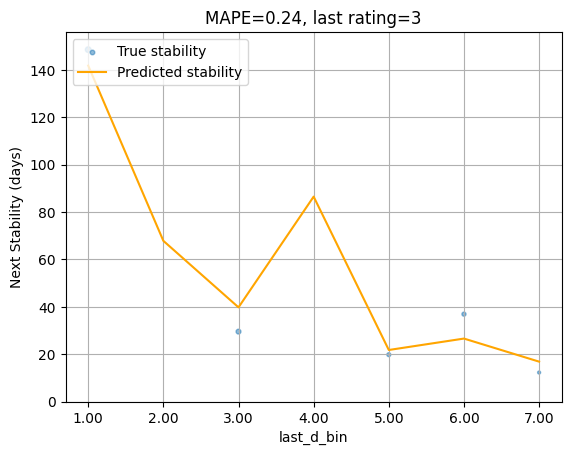

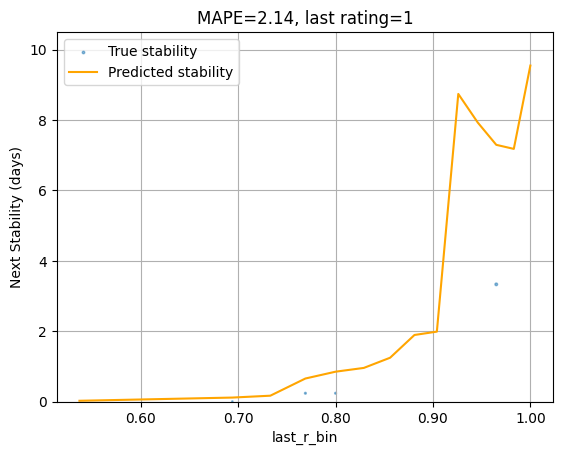

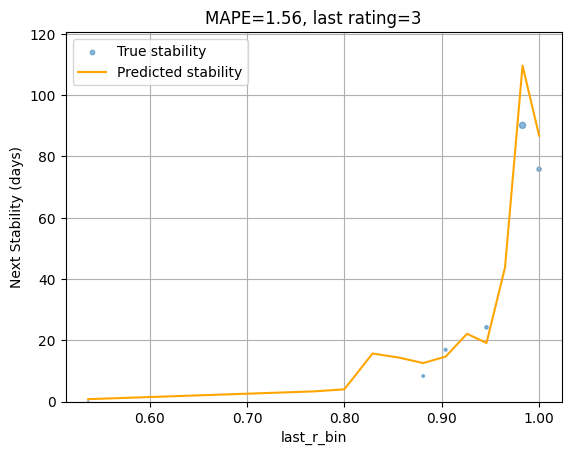

In [12]:
figs = optimizer.formula_analysis()
for f in figs:
    f.show()

### 4.3 Cumulative B-W Metric

For details about Cumulative B-W Metric, please see: [Algorithm SM-17 as a good predictor - supermemo.guru](https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithm_SM-17_as_a_good_predictor)

In [13]:
optimizer.bw_matrix()

d_bin,1,2,3,4,5,6,7
s_bin,,,,,,,
3.840000,,,,,-3.35%,,
5.380000,,,,,-0.49%,0.37%,
7.530000,,,,,0.77%,0.08%,2.98%
10.540000,,,,-0.28%,,-1.11%,-0.97%
14.760000,,,,,,-0.85%,
20.660000,,,-0.47%,,,,
28.930000,,2.22%,-0.32%,,3.33%,-1.44%,
40.500000,,,,-0.41%,,8.41%,
79.370000,-0.36%,,,,,,


### 4.4 Compare with SM-2

For details about universal metric, please see: [Algorithmic contest: SuperMemo 2 vs. SuperMemo 17 - supermemo.guru](https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17)

Loss of SM-2: 0.3484
Universal Metric of FSRS: 0.0139
Universal Metric of SM2: 0.2327


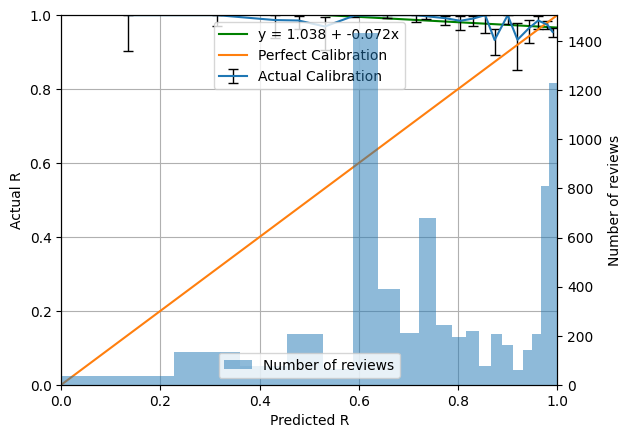

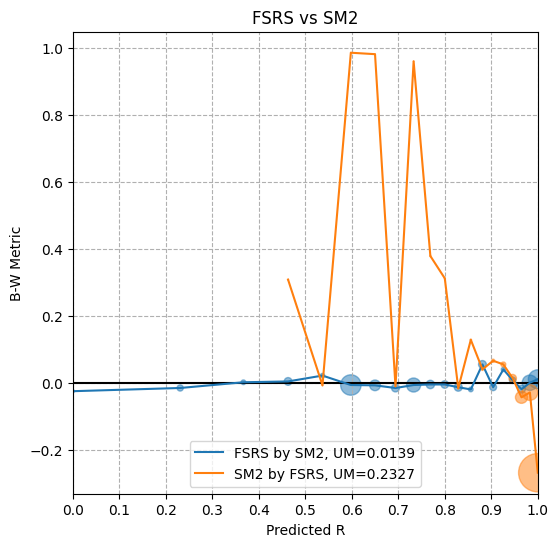

In [14]:
figs = optimizer.compare_with_sm2()
for f in figs:
    f.show()